## Hybrid Movie Recommendation System

*Rishi Dinesh - 19BAI1009* , *Pranav Balaji - 19BAI1151*

The aim of this project is to build a novel hybrid recommendation algorithm that solves two main issues of the existing collaborative filtering algorithm: the case of bad performance due to data sparsity and difficulty in tracking the change of the users’ interest with time. We aim to resolve these issues by bridging the gap between the movie features and the user interests.

### Importing the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the movies dataset
movies = pd.read_csv('./Datasets/movie_data.csv',
                     usecols= ['movieId', 'Title', 'Genre', 'Director', 'Writer', 'Actors'],
                     dtype= {'movieId': 'int64','Title': 'str', 'Genre': 'str', 
                             'Director': 'str', 'Writer': 'str', 'Actors': 'str'})
movies.head()

,movieId,Title,Genre,Director,Writer,Actors
0,1,Toy Story,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney"
1,2,Jumanji,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,3,Grumpier Old Men,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann..."
3,4,Waiting to Exhale,"Comedy, Drama, Romance",Forest Whitaker,"Terry McMillan (novel), Terry McMillan (screen...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,5,Father of the Bride Part II,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [2]:
# Importing the ratings dataset
ratings = pd.read_csv('./Datasets/ratings.csv', usecols= ['userId', 'movieId', 'rating','timestamp'],
                     dtype= {'userId': 'int64','movieId':'int64','rating':'float','timestamp':'int64'})
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Data Preprocessing  

In [9]:
# Filling null values
movies = movies.fillna('')

# Converting attributes from a string to a list of values
movies['Genre'] = movies['Genre'].str.split(', ')
movies['Actors'] = movies['Actors'].str.split(', ')
movies['Writer'] = movies['Writer'].replace(r' \([^\)]*\)', '', regex= True).str.split(', ')
movies['Director'] = movies['Director'].str.split(', ')

movies.head()

,movieId,Title,Genre,Director,Writer,Actors
0,1,Toy Story,"[Animation, Adventure, Comedy, Family, Fantasy]",[John Lasseter],"[John Lasseter, Pete Docter, Andrew Stanton, J...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]"
1,2,Jumanji,"[Adventure, Comedy, Family, Fantasy]",[Joe Johnston],"[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,3,Grumpier Old Men,"[Comedy, Romance]",[Howard Deutch],"[Mark Steven Johnson, Mark Steven Johnson]","[Walter Matthau, Jack Lemmon, Sophia Loren, An..."
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",[Forest Whitaker],"[Terry McMillan, Terry McMillan, Ronald Bass]","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,5,Father of the Bride Part II,"[Comedy, Family, Romance]",[Charles Shyer],"[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Steve Martin, Diane Keaton, Martin Short, Kim..."


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the timestamp to fit between 2016 and 2021 in order to make the recommendations more time-sensitive
scaler = MinMaxScaler(feature_range=(1464199805,1611995861))
scaled_timestamp = scaler.fit_transform(ratings.timestamp.values.reshape(-1,1))
ratings["scaled_timestamp"] = [int(ts) for ts in scaled_timestamp]

ratings.head()

,userId,movieId,rating,timestamp,scaled_timestamp
0,1,1,4.0,964982703,1492701719
1,1,3,4.0,964981247,1492701416
2,1,6,4.0,964982224,1492701619
3,1,47,5.0,964983815,1492701950
4,1,50,5.0,964982931,1492701766


### Feature Vector of Movies

In [15]:
# Function that returns a set of all the unique values of an attribute
def getUnique(column):
    Set = set()
    for field in column:
            for attribute in field: Set.add(attribute)
    return Set

# Storing all then unique values of the genre attribute
features = ["Genre"]
unique = dict()
for feature in features: unique[feature] = list(getUnique(movies[feature]))
print(unique["Genre"])

['Sci-Fi', 'Musical', 'Animation', 'Action', 'Western', 'Comedy', 'Short', 'Horror', 'Family', 'Adventure', 'Film-Noir', 'Music', 'Romance', 'Sport', 'Mystery', 'News', 'Fantasy', 'Thriller', 'Biography', 'History', 'War', 'Documentary', 'Drama', 'Crime']


In [14]:
# Function that builds the feature vectors of the movies
def generateFeatureVectors():
    length = len(unique["Genre"])
    featureVectors = list()
    for row in movies.iterrows():
        movie = row[1]
        vector = np.zeros(length)
        for feature in features:
            for i in range(length):
                if unique[feature][i] in movie[feature] : vector[i] = 1
        featureVectors.append(vector)
    movies["featureVector"] = featureVectors


generateFeatureVectors()

movies.head()


,movieId,Title,Genre,Director,Writer,Actors,featureVector
0,1,Toy Story,"[Animation, Adventure, Comedy, Family, Fantasy]",[John Lasseter],"[John Lasseter, Pete Docter, Andrew Stanton, J...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
1,2,Jumanji,"[Adventure, Comedy, Family, Fantasy]",[Joe Johnston],"[Jonathan Hensleigh, Greg Taylor, Jim Strain, ...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
2,3,Grumpier Old Men,"[Comedy, Romance]",[Howard Deutch],"[Mark Steven Johnson, Mark Steven Johnson]","[Walter Matthau, Jack Lemmon, Sophia Loren, An...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",[Forest Whitaker],"[Terry McMillan, Terry McMillan, Ronald Bass]","[Whitney Houston, Angela Bassett, Loretta Devi...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,5,Father of the Bride Part II,"[Comedy, Family, Romance]",[Charles Shyer],"[Albert Hackett, Frances Goodrich, Nancy Meyer...","[Steve Martin, Diane Keaton, Martin Short, Kim...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."


### Interest Vector of Users

In [7]:
import math
import time

# Function that returns a time based weight parameter
def weightedInterest(beta, timestamp):
    now = int(time.time())
    WD = beta + (1-beta) * math.exp(timestamp-now)
    return WD

# Function that returns the IDF value of all the genres
# Assumption : User is said to have "liked" a movie if rating is greater than 2.5
def inverseFeatureFrequency(feature):
    totalUsers = len(ratings.userId.unique())   
    idf = np.zeros(len(unique[feature]))
    i=0
    for attribute in unique[feature]:
        Filter = list()
        for index,row in movies.iterrows():
            if attribute in row[feature] : Filter.append(row["movieId"])
        df = ratings[ratings.movieId.isin(Filter)]
        df = df[df["rating"]>2.5]
        usersLiked = len(df.userId.unique())
        idf[i] = math.log(totalUsers/usersLiked)
        i += 1
    return idf

genreIDF = inverseFeatureFrequency("Genre")
genreIDF

array([5.04308536e-02, 1.86922288e-01, 5.38528226e-01, 3.35816714e-01,
       1.71235692e-01, 4.68038349e-01, 1.64068946e-03, 2.65796378e-02,
       3.33525762e-01, 1.32015119e-02, 6.57897110e-03, 3.33525762e-01,
       1.32015119e-02, 1.59317739e+00, 1.88085946e+00, 2.65796378e-02,
       3.32241650e+00, 1.40581951e-01, 1.65293020e-02, 3.16429398e-02,
       1.65293020e-02, 1.07112471e+00, 1.86922288e-01, 9.81009556e-02])

In [8]:
# Function that calculates the average rating of every user
def calculateAvgRating():
    uniqueUsers = ratings.userId.unique()
    avgRating = dict()
    for Id in uniqueUsers:
        df = ratings[ratings["userId"]==Id]
        avg = sum(df[:]["rating"])/df.shape[0]
        avgRating[Id] = avg
    return avgRating

rbar = calculateAvgRating()

In [9]:
# users dataframe to store rating and interest vector information
users = pd.DataFrame(list(rbar.items()),columns = ['userId','avgRating']) 
users

,userId,avgRating
0,1,4.366379
1,2,3.948276
2,3,2.435897
3,4,3.555556
4,5,3.636364
...,...,...
605,606,3.657399
606,607,3.786096
607,608,3.134176
608,609,3.270270


In [10]:
# Function that builds the interest vector of all the users and stores it in the users dataframe
def generateInterestVectors(beta):
    interestVectors = list() 
    uniqueUsers = ratings.userId.unique()
    for uid in uniqueUsers:
        vector = np.zeros(len(unique["Genre"]))
        moviesRated = ratings[ratings["userId"]==uid]["movieId"]
        movieVectors = movies[movies.movieId.isin(moviesRated)]["featureVector"]
        avgUserRating = round(float(users[users.userId==uid]["avgRating"]),2)
        for (fVec,mid) in zip(movieVectors,moviesRated):
            row = ratings[(ratings.userId==uid) & (ratings.movieId==mid)]
            userMovieRating = round(float(row["rating"]),4)
            WD = weightedInterest(beta,row["scaled_timestamp"])
            weight = round((userMovieRating-avgUserRating)*WD,4)
            fVec = np.multiply(fVec,weight)
            vector = np.add(vector,fVec)
        vector = np.multiply(vector,genreIDF)
        maxVal = np.max(abs(vector))
        if maxVal==0 : maxVal = 1
        vector = np.divide(vector,maxVal)
        interestVectors.append(np.around(vector,4))
    users["interestVector"] = interestVectors


generateInterestVectors(0.25)
users.head()
            

,userId,avgRating,interestVector
0,1,4.366379,"[-0.1047, 0.5125, -0.0149, 0.0253, 0.1055, 0.0..."
1,2,3.948276,"[-0.0757, 0.0, 0.4809, 0.0136, 0.0765, -0.171,..."
2,3,2.435897,"[0.0037, -0.5861, 0.5832, -0.2633, -0.5369, 0...."
3,4,3.555556,"[-0.0082, 0.0911, 0.0875, 0.3199, 0.062, 0.169..."
4,5,3.636364,"[0.0286, 0.6135, 0.0, 0.0, -0.308, -0.4727, 0...."


### Bridging Movie Features and User Interests

In [11]:
# Function that updates the feature vectors using the interest vectors
def updatefeatureVectors():
    new_fVec = list()
    for index,row in movies.iterrows():
        vector = np.zeros(len(unique["Genre"]))
        mid = row["movieId"]
        userSet = ratings[ratings["movieId"]==mid]["userId"]
        iVecSet = users[users.userId.isin(userSet)]["interestVector"]
        for (iVec,uid) in zip(iVecSet,userSet):
            avgUserRating = round(float(users[users.userId==uid]["avgRating"]),2)
            userMovieRating = round(float(ratings[(ratings.userId==uid) & (ratings.movieId==mid)]["rating"]),4)
            weight = round((userMovieRating-avgUserRating),4)
            iVec = np.multiply(iVec,weight)
            vector = np.add(vector,iVec)
        maxVal = np.max(abs(vector))
        if maxVal==0 : maxVal = 1
        vector = np.divide(vector,maxVal)
        new_fVec.append(vector)
    movies["featureVector"] = new_fVec
     

### Recommendations Based on Interest Vector and Rating Matrix

In [13]:
# Function that calculates the omega parameter value between two users
# Assumption : default X=0
def calculateOmega(u1,u2,mid):
    rVar1 = users[users.userId==u1]["avgRatingVariance"].to_list()[0]
    rVar2 = users[users.userId==u2]["avgRatingVariance"].to_list()[0]
    userSet = ratings[ratings["movieId"]==mid]["userId"]
    rVarSet = users[users.userId.isin(userSet)]["avgRatingVariance"]
    if(len(rVarSet)<=1) : X = 0
    else : X = (max(rVarSet) - max(rVar1,rVar2))/(max(rVarSet)-min(rVarSet))
    return (2*X -(X**2))


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Function that calculates the similarity betweeen two users
# Assumption : If both users have not rated any movies in common, return sim_f
def calculateSimilarity(u1,u2,mid):
    iVec1 = users[users.userId==u1]["interestVector"].to_list()[0].reshape(1,-1)
    iVec2 = users[users.userId==u2]["interestVector"].to_list()[0].reshape(1,-1)
    sim_f = cosine_similarity(iVec1,iVec2)[0][0]
    user1 = ratings[ratings.userId==u1]
    user2 = ratings[ratings.userId==u2]
    common = list(set(user1["movieId"]).intersection(set(user2["movieId"])))
    rVec1 = list(user1[user1.movieId.isin(common)]["rating"])
    rVec2 = list(user2[user2.movieId.isin(common)]["rating"])
    delta = 1e-10
    if(len(common)==0) : return sim_f
    rVec1[0] = rVec1[0] + delta
    rVec2[0] = rVec2[0] + delta
    sim_m = np.corrcoef(rVec1,rVec2)[0][1]
    omega = calculateOmega(u1,u2,mid)
    sim = omega*sim_f + (1-omega)*(sim_m)
    return sim 

In [15]:
# Function that returns the top K similar users to a given user
# Assumption : Get similarity with those users that have rated the movie
np.seterr(divide='ignore')
def getNeighbors(uid,mid,n):
    sims = dict()
    for u in users["userId"]:
        if len(ratings[(ratings.userId==u) & (ratings.movieId==mid)]):
            sims[u] = calculateSimilarity(uid,u,mid)
    sims = sorted(sims.items(), key=lambda x: x[1], reverse=True)
    return(sims[1:n+1])

In [107]:
# Function that predicts the rating that a user might give to a movie
# Assumption : If denominator is 0, default to N*0.5
def predictRating(uid,mid,n):
    KNN = getNeighbors(uid,mid,n)
    num_sum,den_sum= 0,0
    for N in KNN:
        Nrating = ratings[(ratings.userId==N[0]) & (ratings.movieId==mid)]["rating"]
        Navg = float(users[users.userId==N[0]]["avgRating"])
        weight = float(N[1]) * float(Nrating-Navg)
        num_sum += weight
        den_sum += N[1]
    if(den_sum==0): den_sum= n*0.5
    predicted = float(users[users.userId == uid]["avgRating"] + num_sum/den_sum)
    if predicted > 5.0 : predicted = 5.0
    if predicted < 0.0 : predicted = 0.0
    return predicted

### Generating Recommendations for Test User

In [51]:
# Testing the recommender with userID 1. 
# A list of predicted ratings for all the movies is generated and stored in DB
test_user, neighbors, DB = 1, 10, []
for index,row in movies.iterrows():
    predRating = predictRating(test_user,row["movieId"],neighbors)
    DB.append((row["movieId"],predRating))

In [99]:
# Given a movie, the movies with a similar predicted rating are returned as recommendations
movieName = input("Enter a movie you recently watched : ")
dictDB = dict(DB)
expRating = dictDB[int(list(movies[movies["Title"]==movieName]["movieId"])[0])]
recommendations = [item for item in DB if abs(item[1]-expRating)<=0.1]
recommendations.sort(key = lambda x: x[1])
print("You might also like :")
for rec in recommendations[:5] : 
    print(list(movies[movies["movieId"]==rec[0]]["Title"])[0],end="\n")

Enter a movie you recently watched : Jumanji
You might also like :
With Honors
Radio Days
Jay and Silent Bob Strike Back
Basic Instinct 2
U.S. Marshals


### Experimental Results and Analysis

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Analysing the impact of the number of neighbours on the accuracy (MAE)
MAE_neighbors = []
for N in range(5,21):
    test = ratings.sample(frac=.005)
    pred,actual = list(),list()
    for index,row in test.iterrows():
        pred.append(predictRating(row["userId"],row["movieId"],N))
        actual.append(row["rating"])
    df = pd.DataFrame(list(zip(actual,pred)),columns =['Actual', 'Predicted'])
    df = df.fillna(0)
    MAE_neighbors.append(df.eval('Actual-Predicted').abs().mean())
MAE_neighbors

[0.8090975790205733,
 0.6989267976896766,
 0.6961641649145769,
 0.7053809073871208,
 0.7296981282923064,
 0.6827196417938285,
 0.7155749882557759,
 0.7047494230430622,
 0.735468818481935,
 1.4023766883143427,
 0.6956398806047887,
 0.6921012925362082,
 0.7042862869901266,
 0.6991101645934378,
 1.217163493525778,
 0.7149515751717186]

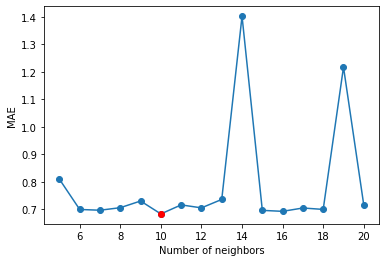

In [47]:
plt.plot(list(range(5,21)),MAE_neighbors,'-o')
plt.plot(MAE_neighbors.index(min(MAE_neighbors)) + 5,min(MAE_neighbors),'ro')
plt.xlabel("Number of neighbors")
plt.ylabel("MAE")
plt.show()

In [18]:
# Analysing the impact of the beta parameter (time based weight) on the accuracy (MAE)
MAE_beta = []
N = MAE_neighbors.index(min(MAE_neighbors)) + 5
for beta in [0,0.25,0.5,0.75,1.0]:
    pred,actual = list(),list()
    test = ratings.sample(frac=.005)
    generateInterestVectors(beta)
    for index,row in test.iterrows():
        pred.append(predictRating(row["userId"],row["movieId"],N))
        actual.append(row["rating"])
    df = pd.DataFrame(list(zip(actual,pred)),columns =['Actual', 'Predicted'])
    df = df.fillna(0)
    MAE_beta.append(df.eval('Actual-Predicted').abs().mean())
MAE_beta

[0.6662950174620058,
 0.7279051285027066,
 0.8143817736432274,
 0.7630739192016945,
 0.7645856918024097]

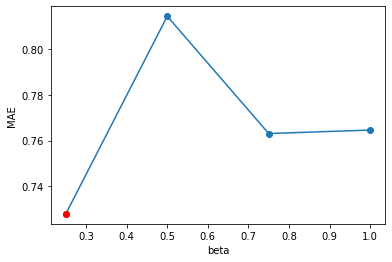

In [48]:
plt.plot([0.25,0.5,0.75,1.0],MAE_beta[1:],'-o')
plt.plot(MAE_beta.index(min(MAE_beta[1:]))*0.25,min(MAE_beta[1:]),'ro')
plt.xlabel("beta")
plt.ylabel("MAE")
plt.show()

In [22]:
# Analysing the improvement of accuracy (MAE) with the number of iterations.
# The interest vectors and feature vectors can be mutually updated in an iterative manner.
MAE_iterations = []
N =  MAE_neighbors.index(min(MAE_neighbors)) + 5
beta =  MAE_beta.index(min(MAE_beta[1:4]))*0.25
for i in range(10):
    updatefeatureVectors()
    generateInterestVectors(beta)
    test = ratings.sample(frac=.001)
    for index,row in test.iterrows():
        pred.append(predictRating(row["userId"],row["movieId"],N))
        actual.append(row["rating"])
    df = pd.DataFrame(list(zip(actual,pred)),columns =['Actual', 'Predicted'])
    df = df.fillna(0)
    MAE_iterations.append(df.eval('Actual-Predicted').abs().mean())
MAE_iterations

[0.7133842074208465,
 0.6964871380828517,
 0.6951055803890168,
 0.7064322764848983,
 0.7101891412080541,
 0.700463265956922,
 0.6995749754279629,
 0.6857391266406233,
 0.6806604264549363,
 0.686587629310321]

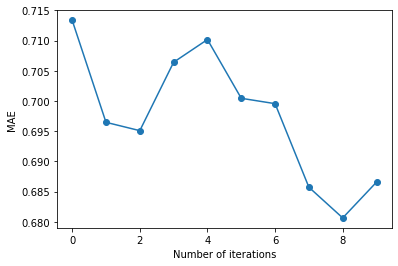

In [49]:
plt.plot(list(range(10)),MAE_iterations,'-o')
plt.xlabel("Number of iterations")
plt.ylabel("MAE")
plt.show()